# Feature Overview

This notebook provides a simple overview of the basic functionality of PySINDy. In addition to demonstrating the basic usage for fitting a SINDy model, we demonstrate several means of customizing the SINDy fitting procedure. These include different forms of input data, different optimization methods, different differentiation methods, and custom feature libraries.

An interactive version of this notebook is available on binder.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v1.7.3?filepath=examples/1_feature_overview.ipynb)

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from derivative import dxdt
from scipy.integrate import solve_ivp
from scipy.integrate import odeint

In [57]:
import warnings
from contextlib import contextmanager
from copy import copy
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.linalg import LinAlgWarning
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import Lasso

import pysindy as ps
from pysindy.utils import enzyme
from pysindy.utils import lorenz
from pysindy.utils import lorenz_control

if __name__ != "testing":
    t_end_train = 10
    t_end_test = 15
else:
    t_end_train = 0.04
    t_end_test = 0.04

data = (Path() / "../data").resolve()


@contextmanager
def ignore_specific_warnings():
    filters = copy(warnings.filters)
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    warnings.filterwarnings("ignore", category=LinAlgWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    yield
    warnings.filters = filters


if __name__ == "testing":
    import sys
    import os

    sys.stdout = open(os.devnull, "w")

In [58]:
# Seed the random number generators for reproducibility
np.random.seed(150)

### A note on solve_ivp vs odeint before we continue
The default solver for `solve_ivp` is a Runga-Kutta method (RK45) but this seems to work quite poorly on a number of these examples, likely because they are multi-scale and chaotic. Instead, the LSODA method seems to perform quite well (ironically this is the default for the older `odeint` method). This is a nice reminder that system identification is important to get the right model, but a good integrator is still needed at the end!

In [59]:
# Initialize integrator keywords for solve_ivp to replicate the odeint defaults
integrator_keywords = {}
integrator_keywords["rtol"] = 1e-12
integrator_keywords["method"] = "LSODA"
integrator_keywords["atol"] = 1e-12

## Basic usage
We will fit a SINDy model to the famous Lorenz system:
$$ \dot{x} = \sigma (y - x),$$
$$ \dot{y} = x(\rho - z) - y, $$
$$ \dot{z} = x y - \beta z. $$


### Train the model

In [60]:
# Generate measurement data
dt = 0.002

t_train = np.arange(0, t_end_train, dt)
x0_train = [-8, 8, 27]
t_train_span = (t_train[0], t_train[-1])
x_train = solve_ivp(
    lorenz, t_train_span, x0_train, t_eval=t_train, **integrator_keywords
).y.T

t_test = np.arange(0, 15, dt)
t_test_span = (t_test[0], t_test[-1])
x0_test = np.array([8, 7, 15])
x_test = solve_ivp(
    lorenz, t_test_span, x0_test, t_eval=t_test, **integrator_keywords
).y.T


In [61]:
t_end_train

10

In [62]:
x_train

array([[-8.        ,  8.        , 27.        ],
       [-7.68350838,  7.96625062, 26.73151854],
       [-7.37398458,  7.92929187, 26.46998075],
       ...,
       [ 7.93562059, 11.84129942, 19.64682377],
       [ 8.01403909, 11.9500649 , 19.7315487 ],
       [ 8.09305564, 12.05853147, 19.81943575]])

In [63]:
# Instantiate and fit the SINDy model
model = ps.SINDy()
model.fit(x_train, t=dt)
model.print()

(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
(x2)' = -2.666 x2 + 1.000 x0 x1


### Assess results on a test trajectory

# My test

In [64]:
feature_names= ['x','y','z']
opt=ps.STLSQ(threshold=1.0)#degree of sparsity  
model2 = ps.SINDy(feature_names=feature_names, optimizer=opt)
model2.fit(x_train, t=dt)
model2.print()

(x)' = -9.999 x + 9.999 y
(y)' = -2.793 x
(z)' = 0.000


C:\Users\fisay\AppData\Roaming\Python\Python39\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (1.0) and eliminated all coefficients
  warnings.warn(


In [65]:
from sklearn.metrics import mean_squared_error
def plot_pareto(coefs, opt, model, threshold_scan, x_test, t_test):
    dt = t_test[1] - t_test[0]
    mse = np.zeros(len(threshold_scan))
    mse_sim = np.zeros(len(threshold_scan))
    for i in range(len(threshold_scan)):
        opt.coef_ = coefs[i]
        mse[i] = model.score(x_test, t=dt, metric=mean_squared_error)
        x_test_sim = model.simulate(x_test[0, :], t_test, integrator="odeint")
        if np.any(x_test_sim > 1e4):
            x_test_sim = 1e4
        mse_sim[i] = np.sum((x_test - x_test_sim) ** 2)
    plt.figure()
    plt.semilogy(threshold_scan, mse, "bo")
    plt.semilogy(threshold_scan, mse, "b")
    plt.ylabel(r"$\dot{X}$ RMSE", fontsize=20)
    plt.xlabel(r"$\lambda$", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    plt.figure()
    plt.semilogy(threshold_scan, mse_sim, "bo")
    plt.semilogy(threshold_scan, mse_sim, "b")
    plt.ylabel(r"$\dot{X}$ RMSE", fontsize=20)
    plt.xlabel(r"$\lambda$", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)

In [66]:
# Make plots of the data and its time derivative
def plot_data_and_derivative(x, dt, deriv):
    feature_name = ["x", "y", "z"]
    plt.figure(figsize=(20, 5))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.plot(x[:, i], label=feature_name[i])
        plt.grid(True)
        plt.xlabel("t", fontsize=24)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.legend(fontsize=24)
    x_dot = deriv(x, t=dt)
    plt.figure(figsize=(20, 5))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.plot(x_dot[:, i], label=r"$\dot{" + feature_name[i] + "}$")
        plt.grid(True)
        plt.xlabel("t", fontsize=24)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.legend(fontsize=24)

In [67]:

# Make an errorbar coefficient plot from the results of ensembling
def plot_ensemble_results(
    model, mean_ensemble, std_ensemble, mean_library_ensemble, std_library_ensemble
):
    # Plot results
    xticknames = model.get_feature_names()
    for i in range(10):
        xticknames[i] = "$" + xticknames[i] + "$"
    plt.figure(figsize=(18, 4))
    colors = ["b", "r", "k"]
    plt.subplot(1, 2, 1)
    plt.xlabel("Candidate terms", fontsize=22)
    plt.ylabel("Coefficient values", fontsize=22)
    for i in range(3):
        plt.errorbar(
            range(10),
            mean_ensemble[i, :],
            yerr=std_ensemble[i, :],
            fmt="o",
            color=colors[i],
            label=r"Equation for $\dot{" + feature_names[i] + r"}$",
        )
    ax = plt.gca()
    plt.grid(True)
    ax.set_xticks(range(10))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    ax.set_xticklabels(xticknames, verticalalignment="top")
    plt.subplot(1, 2, 2)
    plt.xlabel("Candidate terms", fontsize=22)
    for i in range(3):
        plt.errorbar(
            range(10),
            mean_library_ensemble[i, :],
            yerr=std_library_ensemble[i, :],
            fmt="o",
            color=colors[i],
            label=r"Equation for $\dot{" + feature_names[i] + r"}$",
        )
    ax = plt.gca()
    plt.grid(True)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=16, loc="upper right")
    ax.set_xticks(range(10))
    ax.set_xticklabels(xticknames, verticalalignment="top")


In [68]:
# Make 3d plots comparing a test trajectory, 
# an associated model trajectory, and a second model trajectory.
def make_3d_plots(x_test, x_sim, constrained_x_sim, last_label):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection="3d")
    plt.plot(
        x_test[:, 0],
        x_test[:, 1],
        x_test[:, 2],
        "k",
        label="Validation Lorenz trajectory",
    )
    plt.plot(x_sim[:, 0], x_sim[:, 1], x_sim[:, 2], "r", 
             label="SR3, no constraints")
    plt.plot(
        constrained_x_sim[:, 0],
        constrained_x_sim[:, 1],
        constrained_x_sim[:, 2],
        "b",
        label=last_label,
    )
    ax.set_xlabel("x", fontsize=20)
    ax.set_ylabel("y", fontsize=20)
    ax.set_zlabel("z", fontsize=20)
    plt.legend(fontsize=16, framealpha=1.0)
    plt.show()

In [69]:
# For Trapping SINDy, use optimal m, and calculate if identified model is stable
def check_stability(r, Xi, sindy_opt):
    N = int((r ** 2 + 3 * r) / 2.0)
    opt_m = sindy_opt.m_history_[-1]
    PL_tensor_unsym = sindy_opt.PL_unsym_
    PL_tensor = sindy_opt.PL_
    PQ_tensor = sindy_opt.PQ_
    mPQ = np.tensordot(opt_m, PQ_tensor, axes=([0], [0]))
    P_tensor = PL_tensor - mPQ
    As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
    eigvals, eigvecs = np.linalg.eigh(As)
    print("optimal m: ", opt_m)
    print("As eigvals: ", np.sort(eigvals))
    print(
        "All As eigenvalues are < 0 and therefore system is globally stable? ",
        np.all(eigvals < 0),
    )
    max_eigval = np.sort(eigvals)[-1]
    min_eigval = np.sort(eigvals)[0]
    L = np.tensordot(PL_tensor_unsym, Xi, axes=([3, 2], [0, 1]))
    Q = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
    d = np.dot(L, opt_m) + np.dot(np.tensordot(Q, opt_m, axes=([2], [0])), opt_m)
    Rm = np.linalg.norm(d) / np.abs(max_eigval)
    print("Estimate of trapping region size, Rm = ", Rm)

In [70]:
def make_constraints(r):
    q = 0
    N = int((r ** 2 + 3 * r) / 2.0)
    p = r + r * (r - 1) + int(r * (r - 1) * (r - 2) / 6.0)
    constraint_zeros = np.zeros(p)
    constraint_matrix = np.zeros((p, r * N))

    # Set coefficients adorning terms like a_i^3 to zero
    for i in range(r):
        constraint_matrix[q, r * (N - r) + i * (r + 1)] = 1.0
        q = q + 1

    # Set coefficients adorning terms like a_ia_j^2 to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            constraint_matrix[q, r * (N - r + j) + i] = 1.0
            constraint_matrix[
                q, r * (r + j - 1) + j + r * int(i * (2 * r - i - 3) / 2.0)
            ] = 1.0
            q = q + 1
    for i in range(r):
        for j in range(0, i):
            constraint_matrix[q, r * (N - r + j) + i] = 1.0
            constraint_matrix[
                q, r * (r + i - 1) + j + r * int(j * (2 * r - j - 3) / 2.0)
            ] = 1.0
            q = q + 1

    # Set coefficients adorning terms like a_ia_ja_k to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            for k in range(j + 1, r):
                constraint_matrix[
                    q, r * (r + k - 1) + i + r * int(j * (2 * r - j - 3) / 2.0)
                ] = 1.0
                constraint_matrix[
                    q, r * (r + k - 1) + j + r * int(i * (2 * r - i - 3) / 2.0)
                ] = 1.0
                constraint_matrix[
                    q, r * (r + j - 1) + k + r * int(i * (2 * r - i - 3) / 2.0)
                ] = 1.0
                q = q + 1

    return constraint_zeros, constraint_matrix



In [71]:
def Plotting_covid(x,y,approximation=False,u_approximation=0):
    plt.figure(figsize=(12, 7))
    plt.plot(x, y, marker='.', color='blue')
    if approximation==True:
        plt.plot(x, u_approximation, marker='.', color='red')
    plt.title('Increase of Infection Over First 50 Days for Diamond Princess')
    plt.xlabel('Day (Since First Case)')
    plt.ylabel('Number of Confirmed Cases')
    #plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


In [72]:
def CalcAccuracy(Actual_Y, Predicted_y):
    
    actual_values=Actual_Y
    predicted_values=np.array(Predicted_y)
    error= abs(actual_values-predicted_values)
    mse=np.mean(np.square(error))
    rel_err=mse/np.mean(np.square(actual_values))
    accuracy=1-rel_err
    return(accuracy)

In [73]:
def plot_func(x):
    plt.figure(figsize=(12, 7))
    plt.plot(x['Day'],x['CONFIRMED'], marker='.', color='blue')
    plt.plot(x['Day'],x['DEATHS'],  marker='.', color='red')
    plt.plot(x['Day'],x['RECOVERED'],  marker='.', color='green')
    plt.title('Increase of Infection Over First  Days for ')
    plt.xlabel('Day (Since First Case)')
    plt.ylabel('Number of Confirmed Cases')
        #plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# 2a

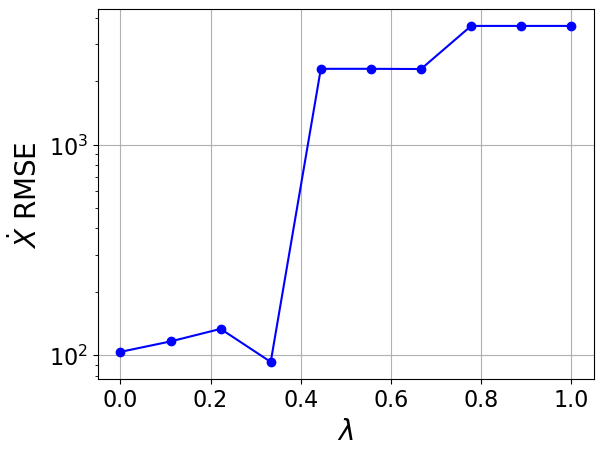

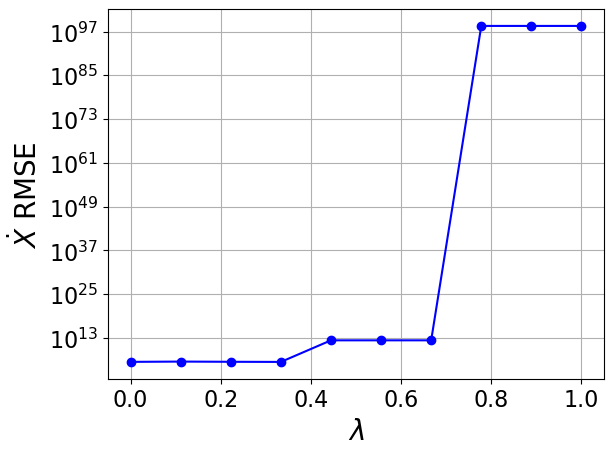

In [74]:
threshold_scan = np.linspace(0, 1.0, 10)
coefs = []
rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
x_train_added_noise = x_train + np.random.normal(0, rmse / 10.0,  x_train.shape)#adding only 10% noise to data and testing how it works
for i, threshold in enumerate(threshold_scan):
    sparse_regression_optimizer = ps.STLSQ(threshold=threshold)
    model3 = ps.SINDy(feature_names=feature_names, 
                     optimizer=sparse_regression_optimizer)
    model3.fit(x_train_added_noise, t=dt, quiet=True)
    coefs.append(model3.coefficients())
    
plot_pareto(coefs, sparse_regression_optimizer, model3, 
            threshold_scan, x_test, t_test)

# 2b and c

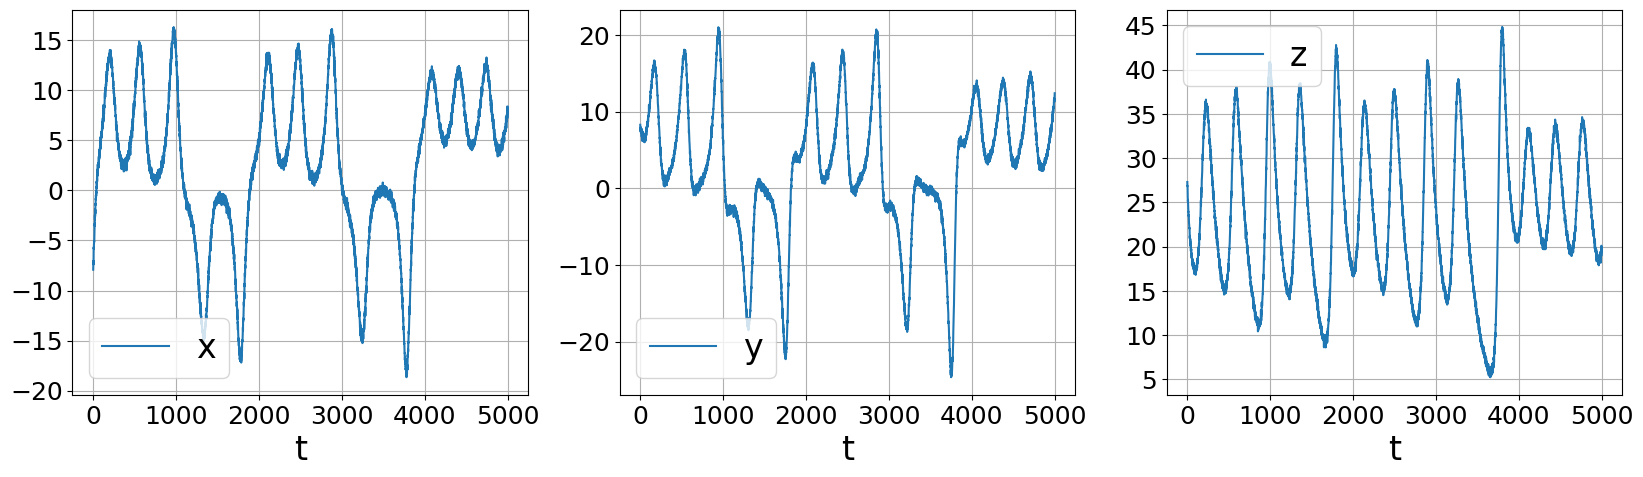

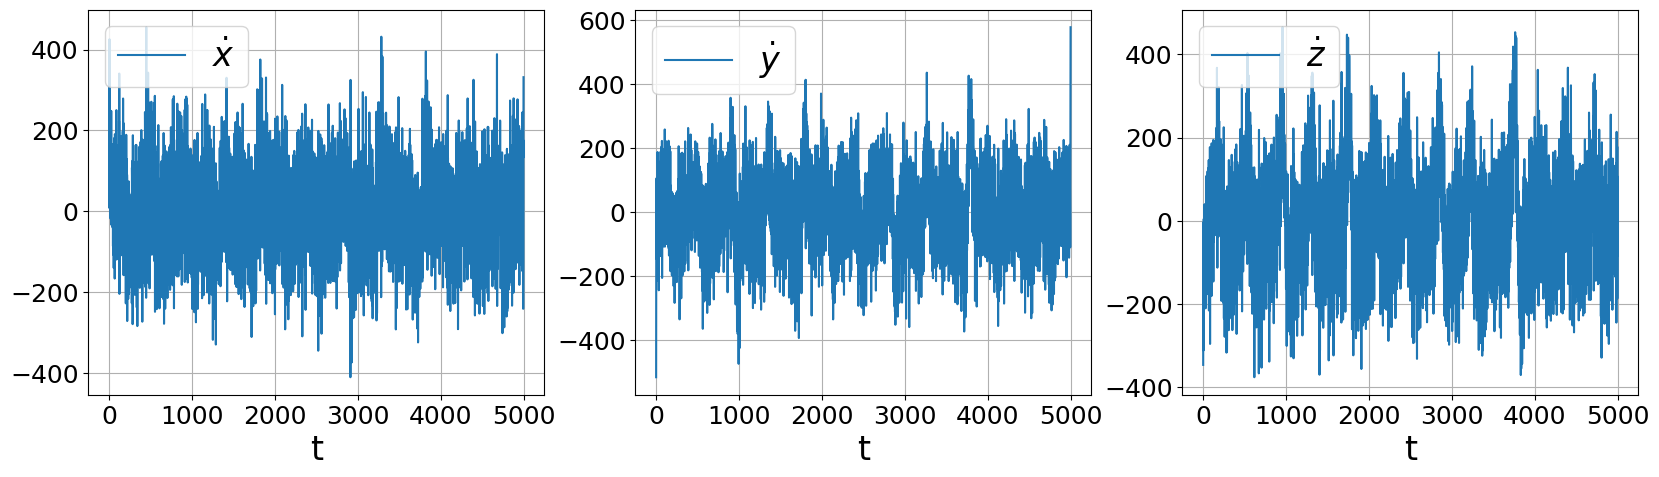

In [75]:
rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
x_train_added_noise = x_train + np.random.normal(0, rmse / 50.0,  x_train.shape) #adding 2% noise
plot_data_and_derivative(x_train_added_noise,dt, ps.FiniteDifference()._differentiate)

adding more trajectory and data 

In [76]:
n_trajectories=40
x0s= (np.random.rand(n_trajectories,3)-0.5)*20
x_train_multi = []
for i in range(n_trajectories):
    x_train_temp=solve_ivp(lorenz,t_train_span,x0s[i], t_eval=t_train, **integrator_keywords).y.T
    rmse = mean_squared_error(x_train_temp, np.zeros(x_train_temp.shape), squared=False)
    x_train_multi.append( x_train_temp + np.random.normal(0, rmse / 50.0,  x_train_temp.shape)) #adding 2% noise
model4 = ps.SINDy(feature_names=feature_names, optimizer=ps.STLSQ())
model4.fit(x_train_multi, t=dt, multiple_trajectories=True)
model4.print()


(x)' = -9.856 x + 9.869 y
(y)' = 27.696 x + -0.909 y + -0.993 x z
(z)' = -2.659 z + 0.997 x y


In [77]:
n_trajectories=40
x0s= (np.random.rand(n_trajectories,3)-0.5)*20
x_train_multi = []
for i in range(n_trajectories):
    x_train_temp=solve_ivp(lorenz,t_train_span,x0s[i], t_eval=t_train, **integrator_keywords).y.T
    rmse = mean_squared_error(x_train_temp, np.zeros(x_train_temp.shape), squared=False)
    x_train_multi.append( x_train_temp + np.random.normal(0, rmse / 50.0,  x_train_temp.shape)) #adding 2% noise
model4 = ps.SINDy(feature_names=feature_names, optimizer=ps.STLSQ())
model4.fit(x_train_multi, t=dt, multiple_trajectories=True)
model4.print()


(x)' = -9.875 x + 9.889 y
(y)' = 27.679 x + -0.896 y + -0.993 x z
(z)' = -0.358 1 + -2.644 z + 0.997 x y


# 2c ensemble method

In [78]:
x_train_added_noise = x_train + np.random.normal(0, rmse / 20.0,  x_train.shape) #adding 5% noise
opt=ps.STLSQ(threshold=0.1)#degree of sparsity  
model5 = ps.SINDy(feature_names=feature_names, optimizer=opt)
model5.fit(x_train_added_noise, t=dt)
model5.print()

(x)' = -0.296 1 + -9.352 x + 9.411 y
(y)' = -0.397 1 + 26.595 x + -0.726 y + -0.961 x z
(z)' = 0.545 1 + -0.336 x + 0.257 y + -2.625 z + 0.982 x y


In [79]:
model5.fit(x_train_added_noise, t=dt, ensemble=True)
mean_ensemble=np.mean(model5.coef_list, axis=0)
std_ensemble=np.std(model5.coef_list, axis=0)

In [80]:
model5.fit(x_train_added_noise, t=dt, library_ensemble=True)
mean_library_ensemble=np.mean(model5.coef_list, axis=0)
std_library_ensemble=np.std(model5.coef_list, axis=0)

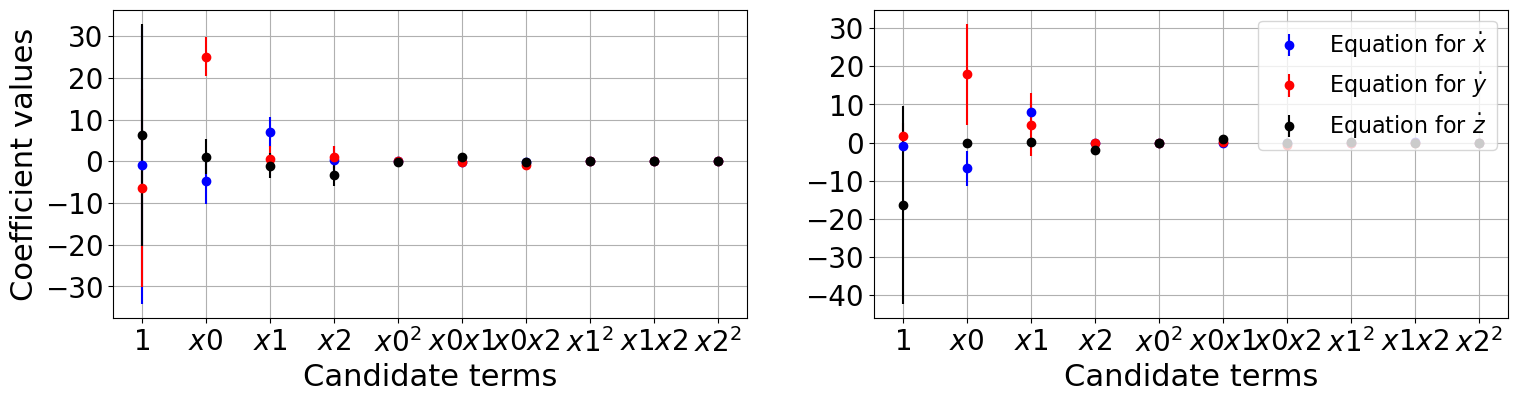

In [81]:
plot_ensemble_results(model, mean_ensemble, std_ensemble, mean_library_ensemble, std_library_ensemble)

In [82]:
mean_ensemble

array([[-8.21613700e-01, -4.69832689e+00,  7.00054538e+00,
         2.16219803e-01,  9.21144604e-02, -1.15480843e-01,
        -1.24812592e-01,  2.97147331e-02,  5.75962347e-02,
        -1.11464103e-02],
       [-6.37372954e+00,  2.50616493e+01,  5.77234623e-01,
         1.03186274e+00,  1.38614558e-01, -6.57243247e-02,
        -9.16365791e-01, -1.14432733e-02, -4.50898385e-02,
        -3.54628622e-02],
       [ 6.27571142e+00,  1.08861613e+00, -1.02038709e+00,
        -3.18923839e+00, -1.11658183e-01,  1.02312640e+00,
        -5.06890255e-02,  1.46476347e-02,  5.35137032e-02,
         1.83756738e-02]])

In [83]:
std_ensemble

array([[33.33574386,  5.48331135,  3.67744358,  3.50381357,  0.4073856 ,
         0.42414201,  0.15575346,  0.16027617,  0.11053352,  0.09270301],
       [23.78895791,  4.73908098,  3.16266142,  2.59136454,  0.36899463,
         0.35027367,  0.13679575,  0.1416301 ,  0.10136707,  0.07645231],
       [26.66812537,  4.1681326 ,  3.01127396,  2.67358019,  0.2223673 ,
         0.20920848,  0.11518026,  0.10757628,  0.09640872,  0.06395991]])

In [84]:
opt=ps.SR3(threshold=0.5, thresholder='l1')#degree of sparsity  
model6 = ps.SINDy(feature_names=feature_names, optimizer=opt)
model6.fit(x_train_added_noise, t=dt)
print('SR3 model, no constraint')
model6.print()
x_sim=model6.simulate(x0_test,t=t_test)

SR3 model, no constraint
(x)' = -0.962 1 + -9.359 x + 9.413 y + 0.029 z
(y)' = -2.116 1 + 26.564 x + -0.718 y + 0.075 z + -0.961 x z
(z)' = 0.545 1 + -0.336 x + 0.257 y + -2.625 z + 0.982 x y


In [85]:
n_targerts=3
n_features=10
constraint_rhs=np.asarray([0,28])
constraint_lhs=np.zeros((2,n_targerts*n_features))

# coefficient of x and the coefficient of y to be equal and opposite
# in equation 1

constraint_lhs[0][1]=1
constraint_lhs[0,2]=1

# coeffiecient of x in the second equation will be = 28
constraint_lhs[1,1 + n_features] = 1

opt = ps.ConstrainedSR3(constraint_rhs=constraint_rhs,constraint_lhs=constraint_lhs, threshold=0.5,thresholder='l1')
model7 = ps.SINDy(feature_names=feature_names, optimizer=opt)
model7.fit(x_train_added_noise, t=dt)
print('Constrained SR3 model, equality constraint:')
model7.print()
x_constrained_sim=model7.simulate(x0_test,t=t_test)

Constrained SR3 model, equality constraint:
(x)' = -7.327 1 + -7.953 x + 7.953 y + 0.569 z
(y)' = -16.263 1 + 27.500 x + -0.915 y + 1.364 z + -0.500 x z
(z)' = 2.477 1 + 1.091 x + -0.978 y + -2.806 z + 0.493 x y


In [86]:
constraint_lhs=np.zeros((3,n_targerts*n_features))
eps=0.5
constraint_rhs=np.asarray([eps,eps,28])
# coefficient of x and the coefficient of y to be equal and opposite
#in equation 1

constraint_lhs[0,1]=1
constraint_lhs[0,2]=1

constraint_lhs[1,1]=-1
constraint_lhs[1,2]=-1

#coeffiecient of x in the second equation will be <= 28

constraint_lhs[2,1 + n_features] = 1

opt = ps.ConstrainedSR3(constraint_rhs=constraint_rhs,constraint_lhs=constraint_lhs, threshold=0.5,thresholder='l1',inequality_constraints=True)
model7 = ps.SINDy(feature_names=feature_names, optimizer=opt)
model7.fit(x_train_added_noise, t=dt)
print('Constrained SR3 model, inequality constraint:')
model7.print()
x_constrained_sim_inequality=model7.simulate(x0_test,t=t_test)

Solver failed, setting coefs to zeros
Constrained SR3 model, inequality constraint:
(x)' = 0.000
(y)' = 0.000
(z)' = 0.000


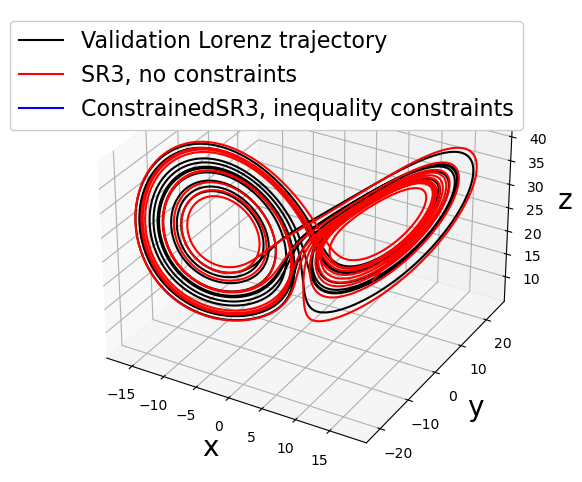

In [87]:
make_3d_plots(
    x_test, x_sim, x_constrained_sim_inequality, 
    "ConstrainedSR3, inequality constraints"
)

trapping sindy

In [88]:
# define hyperparameters
threshold = 0
max_iter = 20000
eta = 1.0e-2
constraint_zeros, constraint_matrix = make_constraints(3)

# run trapping SINDy
sindy_opt = ps.TrappingSR3(
    threshold=threshold,
    eta=eta,
    gamma=-1,
    max_iter=max_iter,
    constraint_lhs=constraint_matrix,
    constraint_rhs=constraint_zeros,
    constraint_order="feature",
)

# Initialize quadratic SINDy library, with custom ordering
library_functions = [lambda x: x, lambda x, y: x * y, lambda x: x ** 2]
library_function_names = [lambda x: x, lambda x, y: x + y, lambda x: x + x]
sindy_library = ps.CustomLibrary(
    library_functions=library_functions, 
    function_names=library_function_names
)

model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)
model.fit(x_train, t=dt, quiet=True)
model.print()

Xi = model.coefficients().T
check_stability(3, Xi, sindy_opt)

(x0)' = -9.528 x0 + 9.741 x1 + -0.050 x2 + -0.020 x0x1 + -0.012 x0x2 + 0.006 x1x2 + 0.014 x1x1 + 0.002 x2x2
(x1)' = 27.321 x0 + -0.576 x1 + 0.056 x2 + -0.014 x0x1 + -0.981 x0x2 + -0.012 x1x2 + 0.020 x0x0 + -0.002 x2x2
(x2)' = 0.076 x0 + -0.074 x1 + -2.676 x2 + 0.975 x0x1 + -0.002 x0x2 + 0.002 x1x2 + 0.012 x0x0 + 0.012 x1x1
optimal m:  [-0.79056771 -0.0781918  36.65605567]
As eigvals:  [-10.01507412  -2.67655747  -0.95969561]
All As eigenvalues are < 0 and therefore system is globally stable?  True
Estimate of trapping region size, Rm =  102.6435227232408


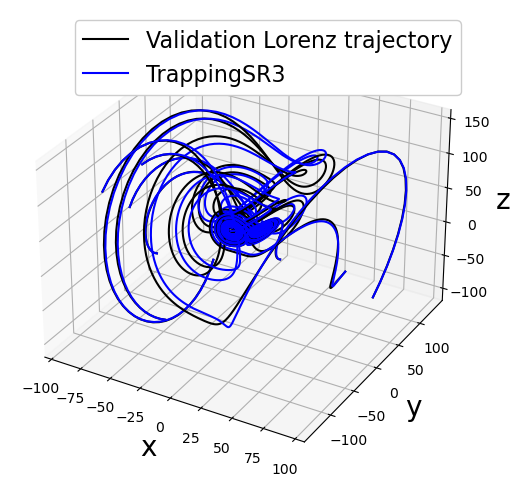

In [89]:
# show that new model trajectories are all stable
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111, projection="3d")
for i in range(10):
    x0_new = (np.random.rand(3) - 0.5) * 200
    x_test_new = solve_ivp(
        lorenz, t_test_span, x0_new, t_eval=t_test, **integrator_keywords
    ).y.T
    ax.plot(x_test_new[:, 0], x_test_new[:, 1], x_test_new[:, 2], "k")
    x_test_pred_new = model.simulate(x0_new, t=t_test, integrator="odeint")
    plt.plot(x_test_pred_new[:, 0], x_test_pred_new[:, 1], 
             x_test_pred_new[:, 2], "b")
    ax.set_xlabel("x", fontsize=20)
    ax.set_ylabel("y", fontsize=20)
    ax.set_zlabel("z", fontsize=20)
    plt.legend(
        ["Validation Lorenz trajectory", "TrappingSR3"], 
        fontsize=16, framealpha=1.0
    )

Weak formulation of sidney

Normal SINDy result on 10% Lorenz noise: 
(x)' = 5.273 1 + -3.427 x + 7.565 y + -0.194 z + -0.098 x^2 + 0.324 x y + -0.135 x z + -0.185 y^2
(y)' = -3.938 1 + 7.550 x + 9.345 y + 0.664 z + -0.294 x^2 + 0.563 x y + -0.449 x z + -0.272 y^2 + -0.258 y z
(z)' = 0.426 1 + 0.071 x + -0.107 y + -2.821 z + 0.308 x^2 + 0.360 x y + 0.277 y^2
Weak form result on 10% Lorenz noise: 
(x)' = 0.571 1 + -9.891 x + 9.891 y
(y)' = -0.449 1 + 28.964 x + -1.252 y + -1.025 xz
(z)' = -1.099 1 + -0.152 y + -2.581 z + 0.986 xy


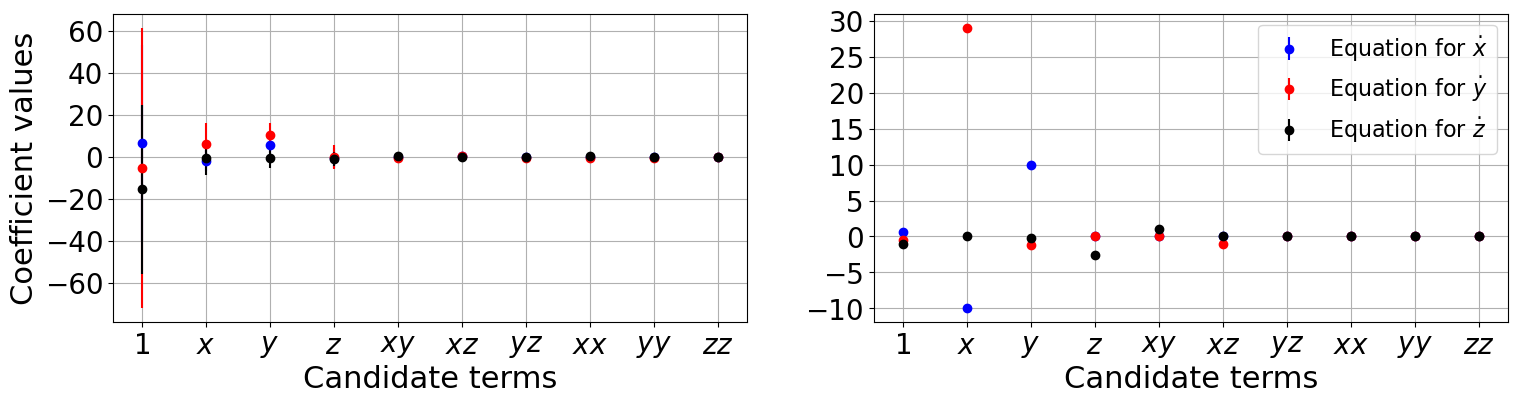

In [90]:
ode_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    spatiotemporal_grid=t_train,
    include_bias=True,
)
rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
x_train_added_noise = x_train + np.random.normal(0, rmse / 10.0, x_train.shape)

# Fit a normal SINDy model
optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=optimizer)
model.fit(x_train_added_noise, t=dt, ensemble=True)

print("Normal SINDy result on 10% Lorenz noise: ")
model.print()
regular_models = model.coef_list
regular_mean = np.mean(regular_models, axis=0)
regular_std = np.std(regular_models, axis=0)

# Instantiate and fit a weak formulation SINDy model
optimizer = ps.STLSQ()
model = ps.SINDy(
    feature_library=ode_lib, 
    feature_names=feature_names, 
    optimizer=optimizer
)
model.fit(x_train_added_noise, t=dt, ensemble=True)
print("Weak form result on 10% Lorenz noise: ")
model.print()
weak_form_models = model.coef_list
weak_form_mean = np.mean(weak_form_models, axis=0)
weak_form_std = np.std(weak_form_models, axis=0)

plot_ensemble_results(model, regular_mean, regular_std, 
                      weak_form_mean, weak_form_std)